## Names

Get all the names of the supported coins on coingecko (https://www.coingecko.com/) by making one api call

Steps:
- Coin Gecko API call
- Sort by marketcap

In [1]:
# Gets the ids and symbols for each coin listed on coingecko
import requests
import json
response = requests.get("https://api.coingecko.com/api/v3/coins/list")
if response.status_code == 200:
    data = response.json()
else:
    print("Request was not a success")
import pandas as pd
df = pd.DataFrame(data, columns=data[0].keys())

In [2]:
df.to_csv('./NamesFromCoinGecko.csv',index = False)

#### Experimenting with locating elements in a Pandas Dataframe

In [185]:
%timeit df.loc[0,['id']]

535 µs ± 61.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [44]:
%timeit df['id'][0]

4.81 µs ± 373 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [262]:
df.loc[:3,:]

,id,symbol,name
0,01coin,zoc,01coin
1,0chain,zcn,Zus
2,0vix-protocol,vix,0VIX Protocol
3,0x,zrx,0x Protocol


We can conclude that accessing columns of the dataframe has its advantages interms of speed. However using .loc to access specific rows with numeric indexing with specific column names, adds additional funcitonality. We can accomplish the same using series however we would need to access the columns of the entire dataframe which is expensive.

## Get Market Cap by using the Gecko API

We need to call the market data api with the desired coin id sent with the api call. There are several limitations to this, namely a limit on the amount of data we can retrieve per api call as well as the number of times we can call the api in a day.

Split the ids of the coin into batches since there is a batch limit when using the Gecko API

In [3]:
import numpy as np
batch_size = 100
batches = [','.join(df.id[e:np.min([e+batch_size,len(df.id)])]) for e in range(0,len(df.id) - len(df.id)%batch_size+batch_size,batch_size)]

Note that the API returns data in an unstructured way. So cannot iterate incrementally through both the current and received list of ids. We need to manually match these.

Update:
I realised we could have created a dataframe from the response and then merged the final dataframes by column 'symbol'.

Need to run this on a while loop and use raspberry pi. This will take approximately 1 day to collect the required data

In [22]:
from urllib.parse import quote
import time
import datetime
ids_ = quote(batches[0]) #Converts string to normal url code i.e. , replace by %C

cross_reference_check_Name = df.name

#Uncomment these lines if running for the first time
new_df_rows = [] # Stores culmination of rows of each api call
k=0  #k is used to index the reference df.

#Introduce batch numbers since the free api limits requests of 10-30 per 30 minutes depending on traffic.
#Get around is to activate vpn in a different country every time the rate limit has been exceeded.
batch_num =0
for batch in batches:
    if batch_num<-1:
        batch_num +=1
        continue

    #The response outputs a list of dictionaries
    response = requests.get("https://api.coingecko.com/api/v3/coins/markets?vs_currency=gbp&ids=" + batch+"&order=market_cap_desc&per_page=100&page=1&sparkline=false&locale=en")
    
    if response.status_code == 200:
        print("Conncetion successful")
        data = response.json()
        for i in range(0,batch_size):
            if k+i > len(cross_reference_check_Name): # Check if we have found all the required ids
                break

            #Find dictionary in the response which corresponds with the intial dataset
            dictionary = next((item for item in data if item['name'] ==cross_reference_check_Name[k+i]),None)
            if dictionary == None:
                continue

            #Construct the dataframe by creating a list of rows and adding to this global list
            desired_categories = ['name','market_cap','market_cap_rank','total_supply','max_supply','circulating_supply','image','ath_date','atl_date']
            row = [dictionary.get(key) for key in desired_categories]
            new_df_rows.append(row)
        
        #Update indexing
        k+=batch_size
        batch_num+=1
        print("1minstart: ", datetime.datetime.now().time())
        time.sleep()

    else:
        print("Connection unsuccessful on batch: ",batch_num)
        break

Conncetion successful
1minstart:  22:00:49.977552
Conncetion successful
1minstart:  22:01:51.488709
Conncetion successful
1minstart:  22:02:53.040903
Conncetion successful
1minstart:  22:03:54.578450
Conncetion successful
1minstart:  22:04:56.408044
Conncetion successful
1minstart:  22:05:58.228493
Conncetion successful
1minstart:  22:07:00.508801
Conncetion successful
1minstart:  22:08:02.011535
Conncetion successful
1minstart:  22:09:03.627991
Conncetion successful
1minstart:  22:10:05.106990
Conncetion successful
1minstart:  22:11:06.963982
Conncetion successful
1minstart:  22:12:08.463330
Conncetion successful
1minstart:  22:13:10.398170
Conncetion successful
1minstart:  22:14:11.865183
Conncetion successful
1minstart:  22:15:13.544749
Conncetion successful
1minstart:  22:16:15.429672
Conncetion successful
1minstart:  22:17:16.936416
Conncetion successful
1minstart:  22:18:18.425654
Conncetion successful
1minstart:  22:19:20.429775
Conncetion successful
1minstart:  22:20:21.914643


KeyError: 10194

In [23]:
len(new_df_rows)

10194

### Create a dataframe where we have the market caps and names symbols etc.

In [24]:
merged_dataframe = pd.merge(df,pd.DataFrame(new_df_rows,columns = desired_categories), on = 'name', how = 'inner')

Checking that there are no duplicates.

Concluded that there are duplicates so need to merge by a different column. that is change to ```name```. (Completed)

In [25]:
len(pd.DataFrame(new_df_rows,columns = desired_categories))
len(df)
len(merged_dataframe.index.values)

10194

In [26]:
merged_dataframe

,id,symbol,name,market_cap,market_cap_rank,total_supply,max_supply,circulating_supply,image,ath_date,atl_date
0,01coin,zoc,01coin,0.0,NaN,6.565882e+07,NaN,0.000000e+00,https://assets.coingecko.com/coins/images/5720...,2018-10-10T17:27:38.034Z,2022-07-04T08:03:24.254Z
1,0chain,zcn,Zus,4938370.0,1147.0,4.000000e+08,NaN,4.840098e+07,https://assets.coingecko.com/coins/images/4934...,2021-11-10T12:21:06.184Z,2021-12-14T21:31:35.868Z
2,0vix-protocol,vix,0VIX Protocol,NaN,NaN,NaN,NaN,NaN,https://assets.coingecko.com/coins/images/2908...,None,None
3,0x,zrx,0x Protocol,156556005.0,179.0,1.000000e+09,1.000000e+09,8.474961e+08,https://assets.coingecko.com/coins/images/863/...,2018-07-28T14:41:06.104Z,2020-03-13T02:27:49.563Z
4,0x0-ai-ai-smart-contract,0x0,0x0.ai: AI Smart Contract,35891246.0,451.0,8.912500e+08,1.000000e+09,8.912500e+08,https://assets.coingecko.com/coins/images/2888...,2023-05-21T09:08:13.239Z,2023-02-01T14:29:44.928Z
...,...,...,...,...,...,...,...,...,...,...,...
10189,zynergy,zyn,Zynergy,0.0,NaN,1.000000e+07,NaN,0.000000e+00,https://assets.coingecko.com/coins/images/2967...,2023-04-15T11:58:01.027Z,2023-04-25T10:43:03.436Z
10190,zyro,zyro,Zyro,0.0,NaN,3.000000e+08,NaN,0.000000e+00,https://assets.coingecko.com/coins/images/1246...,2020-09-14T06:14:47.027Z,2022-05-12T22:04:51.349Z
10191,zyrri,zyr,Zyrri,0.0,NaN,NaN,NaN,0.000000e+00,https://assets.coingecko.com/coins/images/2406...,2022-03-24T22:15:29.407Z,2022-05-09T00:02:58.623Z
10192,zyx,zyx,ZYX,765792.0,2058.0,2.223828e+08,9.000000e+08,1.233660e+08,https://assets.coingecko.com/coins/images/1196...,2021-02-21T19:14:34.629Z,2021-11-03T17:06:15.082Z


There are duplicated symbols

In [27]:
duplicate_rows = df[df['symbol'].duplicated()]
print(duplicate_rows)

                     id symbol                name
28     1sol-io-wormhole   1sol  1sol.io (Wormhole)
94          aave-bat-v1   abat         Aave BAT v1
96         aave-busd-v1  abusd        Aave BUSD v1
99          aave-dai-v1   adai         Aave DAI v1
101         aave-enj-v1   aenj         Aave ENJ v1
...                 ...    ...                 ...
10172            zoodao    zoo              ZooDAO
10173         zookeeper    zoo           ZooKeeper
10178               zro    zro           Carb0n.fi
10186              zusd   zusd                ZUSD
10189           zynergy    zyn             Zynergy

[1530 rows x 3 columns]


In [254]:
not df['symbol'].duplicated().any()

False

In [28]:
merged_dataframe['market_cap'].describe()

count    9.768000e+03
mean     9.975969e+07
std      4.858032e+09
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      3.535565e+05
max      4.342652e+11
Name: market_cap, dtype: float64

Plot the histogram of coins that have market caps that are greater than 1 mil.

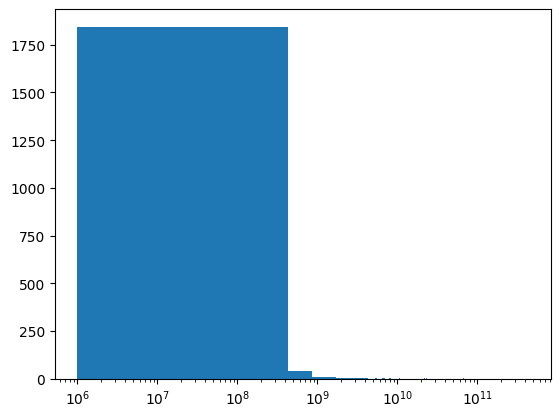

In [33]:
import matplotlib.pyplot as plt
plt.hist(list(merged_dataframe[merged_dataframe['market_cap']>1e6]['market_cap']),bins = 1000)
plt.xscale("log")
plt.show()

In [42]:
MarketCap_threshold_lower_bound = 1e6
df_ = merged_dataframe[merged_dataframe['market_cap']>MarketCap_threshold_lower_bound]
df_.to_csv('./Coins.csv',index = False)


In [43]:
len(df_)

1927

Need to draw conclusions from this plot

## Whitepapers and URL

Steps:

1. Check if we can find the same coin on both coingecko and golden
2. Get the links to the whitepapers and official websites from Golden
3. Get the same from Coin Gecko
4. Search google for the whitepaper by using the suffix 'filetype:pdf'
5. Build a depth-1 webcrawler to scrape text off websites (used for gitbooks but can be used for any website)

In [7]:
import pandas as pd
df = pd.read_csv('./Coins.csv')

In [8]:
df[df['market_cap']>1e7]

,id,symbol,name,market_cap,market_cap_rank,total_supply,max_supply,circulating_supply,image,ath_date,atl_date
1,0x,zrx,0x Protocol,156556005.0,179.0,1.000000e+09,1.000000e+09,8.474961e+08,https://assets.coingecko.com/coins/images/863/...,2018-07-28T14:41:06.104Z,2020-03-13T02:27:49.563Z
2,0x0-ai-ai-smart-contract,0x0,0x0.ai: AI Smart Contract,35891246.0,451.0,8.912500e+08,1.000000e+09,8.912500e+08,https://assets.coingecko.com/coins/images/2888...,2023-05-21T09:08:13.239Z,2023-02-01T14:29:44.928Z
4,1inch,1inch,1inch,260057828.0,122.0,1.500000e+09,1.500000e+09,8.172430e+08,https://assets.coingecko.com/coins/images/1346...,2021-10-27T08:24:54.808Z,2022-12-30T22:50:09.998Z
9,aave,aave,Aave,774271893.0,49.0,1.600000e+07,1.600000e+07,1.440192e+07,https://assets.coingecko.com/coins/images/1264...,2021-05-18T21:19:59.514Z,2020-11-05T09:20:11.928Z
10,aavegotchi,ghst,Aavegotchi,40736348.0,415.0,5.274780e+07,5.274780e+07,5.115724e+07,https://assets.coingecko.com/coins/images/1246...,2021-11-25T10:34:20.480Z,2020-12-01T23:14:48.358Z
...,...,...,...,...,...,...,...,...,...,...,...
1913,zignaly,zig,Zignaly,31797155.0,472.0,2.000000e+09,2.000000e+09,0.000000e+00,https://assets.coingecko.com/coins/images/1479...,2021-04-15T15:39:42.111Z,2023-05-15T04:45:28.788Z
1914,zigzag-2,zz,ZigZag,11922857.0,842.0,1.000000e+08,1.000000e+08,5.863489e+07,https://assets.coingecko.com/coins/images/2614...,2022-12-12T18:55:50.106Z,2023-01-30T14:34:42.918Z
1917,zilliqa,zil,Zilliqa,315729300.0,102.0,1.759089e+10,2.100000e+10,1.654171e+10,https://assets.coingecko.com/coins/images/2687...,2021-05-06T17:33:45.940Z,2020-03-13T02:22:55.161Z
1923,zoid-pay,zpay,ZoidPay,17473450.0,695.0,7.000000e+08,7.000000e+08,3.920000e+08,https://assets.coingecko.com/coins/images/1681...,2022-04-26T08:50:35.666Z,2022-12-20T02:32:27.462Z


1. Check if we can find the same coin on both coingecko and golden

In [50]:
from bs4 import BeautifulSoup
import requests
test_name = 'ACryptoS'

url = 'https://golden.com/search/' +test_name 

response = requests.get(url)
html_content = response.content

soup = BeautifulSoup(html_content, 'html.parser')
all_links = soup.find_all('a')

#Scan for all hyperlinks
hyperlinks = [link.get('href') for link in all_links]

#If a hyper link contains the name then we can conclude that the coin name initially from coin gecko is in the Golden Database
for link in hyperlinks:
    contains = False
    if 'wiki/'+test_name in link:
        wiki_url = 'https://golden.com'+link + '/structured_data'
        contains = True
        print("The coingecko named coin is also in the golden database")
        break
if contains == False:
    print('Doesn\'t have a correspondence with golden')


The coingecko named coin is also in the golden database


2. Get the links to the whitepapers and official website from Golden

- Use the above code to find the link to the wikipage in Golden.
- Scan the golden wikipage to get the official website and the whitepaper.

In [355]:
from bs4 import BeautifulSoup
import requests

# make a GET request to the webpage
response = requests.get(wiki_url)


# parse the content with BeautifulSoup
soup = BeautifulSoup(response.text, 'html.parser')

# find the unnested div containing the word 'Whitepaper'
div_with_whitepaper = soup.find(lambda tag: tag.name == "div" and "Whitepaper" in tag.text and not tag.find('div'))
if div_with_whitepaper == None:
    print('No links to whitepaper')
# find the next div
next_div = div_with_whitepaper.find_next('div')

# find all 'a' tags within this div
a_tags = next_div.find_all('a')

# get the links
whitepaper_links = [a_tag.get('href') for a_tag in a_tags]

# print the links
print('whiepaper_links: \n',whitepaper_links)

# find the unnested div containing the word 'Whitepaper'
div_with_off_website = soup.find(lambda tag: tag.name == "div" and "Official Website" in tag.text and not tag.find('div'))
if div_with_off_website == None:
    print('No official website tag')

# find the next div
next_div = div_with_off_website.find_next('div')

# find all 'a' tags within this div
a_tags = next_div.find_all('a')

# get the links
website_links = [a_tag.get('href') for a_tag in a_tags]

# print the links
print('website_links: \n', website_links)

whiepaper_links: 
 ['https://docs.acryptos.com/']
website_links: 
 ['https://acryptos.com', 'https://app-v2.acryptos.com', 'https://app.acryptos.com', 'https://medium.com/acryptos']


2. Get the links to the whitepapers and official website from CoinGecko

- Access page by the 'id' of the row.
- Check if the div contains the links to whitepapers
- Check if the div contains links to the official website

Updates:
- I was getting errors when using Beautifull Soup, presumably as a result of coingecko having rate limits from Beautiful Soup when accessing website
- Used Selenium instead (Takes longer and more computationally expensive) but may be able to bypass waiting time to refresh (Correct)

In [5]:
from bs4 import BeautifulSoup
import requests
# assuming 'html' variable contains your page HTML
response = requests.get('https://www.coingecko.com/en/coins/quant')
if response.status_code != 200:
    print("Connection Unsuccessful")
    print(response.status_code)

html = response.text
soup = BeautifulSoup(html, 'html.parser')

div_with_website = None
for span in soup.find_all('span'):
    if 'Website' in span.text:
        div_with_website = span.find_parent('div')
        break
print(div_with_website)


Connection Unsuccessful
403
None


In [6]:
from selenium import webdriver
from selenium.webdriver.common.by import By

# Set up the Selenium WebDriver
driver = webdriver.Chrome() 

In [7]:
driver.get('https://www.coingecko.com/en/coins/swaprum')
print("hi")

hi


In [397]:
driver.get('https://www.coingecko.com/en/coins/swaprum')
print("hi")
div_with_website = driver.find_element(By.XPATH,"//span[contains(text(), 'Website')]/ancestor::div[1]")

whitepaper_links = []
website_links = []
html_text = div_with_website.get_attribute('innerHTML')
if 'Website' in div_with_website.text:
    inner_div = div_with_website.find_element(By.TAG_NAME,'div')
    a_tags = inner_div.find_elements(By.TAG_NAME,'a')
    for tag in a_tags:
        if 'Whitepaper' in tag.text:
            whitepaper_links.append(tag.get_attribute("href"))
        else:
            website_links.append(tag.get_attribute("href"))
    # Print the HTML text
else:
    print("Doesn't contain a link")

print("Websites: ", website_links)
print("Whitepapers: ", whitepaper_links)
    

Websites:  ['https://swaprum.finance/']
Whitepapers:  ['https://swaprum-finance.gitbook.io/swaprum/']


4. Search google for the whitepaper by using the suffix 'filetype:pdf'

In [9]:
test_name = 'frax'
url ='https://www.google.co.uk/search?q='+test_name+'+whitepaper+filetype%3Apdf'

response = requests.get(url)

hyperlink_pdf = []
if response.status_code == 200:
    #Get the first search result that is a pdf and contains the name of the crypto in the hyperlink
    html_content = response.content
    soup = BeautifulSoup(html_content, 'html.parser')
    all_links = soup.find_all('a')
    for link in all_links:
        if test_name in link.get("href") and 'search' not in link.get("href") and '.pdf' in link.get("href"):
            hyperlink_pdf.append('https://www.google.co.uk' +link.get("href"))
            break


    file_name = hyperlink_pdf[0].split('/')[-1]  # Extract the file name from the URL
    pdf_index = file_name.find(".pdf") + 4  # Find the index of ".pdf" and add 4 to include the ".pdf" itself
    file_name = file_name[:pdf_index]
    response = requests.get(hyperlink_pdf[0])

    # Save the PDF file
    with open(file_name, 'wb') as file:
        file.write(response.content)
        print(f"Downloaded {file_name}")
else:
    print("Connection unsuccessful")

Connection unsuccessful


In [12]:
from selenium import webdriver
from selenium.webdriver.common.by import By
import requests
from urllib.parse import quote

driver = webdriver.Chrome()
name = 'frax'
url ='https://www.google.co.uk/search?q='+quote(name)+'+whitepaper+filetype%3Apdf'

In [19]:
driver.get(url)
links = driver.find_elements(By.XPATH,'//a[@href]')

for link in links:
    if name in link.get_attribute("href") and 'search' not in link.get_attribute("href") and '.pdf' in link.get_attribute("href"):
        print(link.get_attribute("href"))

https://fraxeum.com/wp-content/uploads/2020/10/Fraxeum_Whitepaper.pdf


In [10]:
response.status_code

429

5. Build a depth-1 webcrawler to scrape text off websites (used for gitbooks but can be used for any website)

Use gitbook2pdf to get the text file from a website that is in the form of a gitbook. To use gitbook2pdf need to upgrade windows to 11. So need to use other laptop. Alternatively, use a webcrawler since this is generalised.

Find all hyperlinks of hyperlinks (depth-1)

In [1]:
import requests
from bs4 import BeautifulSoup

url = 'https://ir0nstone.gitbook.io/crypto'
base_url = 'https://ir0nstone.gitbook.io'
# Send a GET request to the URL
response = requests.get(url)

# Create a BeautifulSoup object to parse the HTML content
soup = BeautifulSoup(response.content, 'html.parser')

# Find all <a> tags (hyperlinks) within the HTML
links = soup.find_all('a')

# Extract and print the href attribute of each <a> tag
paths = []
for link in links:
    href = link.get('href')
    if 'https' in href:
        continue
    paths.append(href)

    url = base_url + href
    response = requests.get(url)
    soup = BeautifulSoup(response.content,'html.parser')
    links = soup.find_all('a')

    for link in links:
        href = link.get('href')
        if href not in paths:
            paths.append(href)

#Refine supported paths
paths = [elem for elem in paths if elem[0] == '/']
paths = list(set(paths))
for elem in paths:
    print(elem)

/crypto/
newurl:  https://ir0nstone.gitbook.io/crypto/
/crypto/
newurl:  https://ir0nstone.gitbook.io/crypto/
/crypto/
newurl:  https://ir0nstone.gitbook.io/crypto/
/crypto/fundamentals/divisibility-factors-and-euclids-algorithms
newurl:  https://ir0nstone.gitbook.io/crypto/fundamentals/divisibility-factors-and-euclids-algorithms
/crypto/fundamentals/modular-arithmetic
newurl:  https://ir0nstone.gitbook.io/crypto/fundamentals/modular-arithmetic
/crypto/fundamentals/rings-fields-and-eulers-totient-function
newurl:  https://ir0nstone.gitbook.io/crypto/fundamentals/rings-fields-and-eulers-totient-function
/crypto/further-maths/continued-fractions
newurl:  https://ir0nstone.gitbook.io/crypto/further-maths/continued-fractions
/crypto/rsa/overview
newurl:  https://ir0nstone.gitbook.io/crypto/rsa/overview
/crypto/rsa/public-exponent-attacks
newurl:  https://ir0nstone.gitbook.io/crypto/rsa/public-exponent-attacks
/crypto/rsa/choice-of-primes
newurl:  https://ir0nstone.gitbook.io/crypto/rsa/cho

Convert all hyperlinks contents to one text file. I need to generalise the code since I have to manually change the url/base url 

In [35]:
import requests
from bs4 import BeautifulSoup

base_url = 'https://ir0nstone.gitbook.io/'

# Open the text file in write mode
with open('website_content.txt', 'w',encoding = 'utf-8') as f:
    # Loop through each URL path
    for path in paths:
        # Check if the path is a complete URL or a path on the base URL
        if path.startswith('http'):
            url = path
        else:
            url = base_url + path

        # Send a request to the website
        r = requests.get(url)

        # Parse the HTML content of the website
        soup = BeautifulSoup(r.text, 'html.parser')

        # Extract the text from the parsed HTML
        text = soup.get_text()

        # Write the text to the file, followed by a newline
        f.write(text + '\n')

Make text file printable for a4, by wrapping lines onto the next line

In [36]:
import textwrap

# Open your file
with open('website_content.txt', 'r',encoding = 'utf-8') as f:
    lines = f.readlines()

# Reformat the lines
wrapped_lines = [textwrap.fill(line, width=60) for line in lines]

# Write the lines back to the file
with open('website_content.txt', 'w',encoding = 'utf-8') as f:
    f.write('\n'.join(wrapped_lines))

## Twitter


Need to do

### Side Tracked Comments

Use Golden API?

Compiling fragmented information from the web with modern NLP
Golden uses sophisticated natural language processing techniques to extract canonical information on topics and entities from a wide range of public and private sources.

We ingest data from numerous sources and mine our own knowledge graph in order to provide useful insights.

https://docs.golden.com/reference/companyenrichment

- List of venues? use https://coinmap.org/api/v1/venues/ 
- Contains a list of 25 or so coins that are used to transact in

## Creation Date

- Get publishing date- i.e. creation date from pdf by metadata
- Check WikiData
- Scan first few rows of pdf for a date

## Version

Use MetaData?
- Use wikidata

## Address - physical address

## Registered Number

## People(founders/authors)

- Cross Reference contents of text file against a list of names: https://www.back4app.com/database/back4app/list-of-names-dataset

- Use Dandelion API for name extraction from the entire pdf. (1000 daily requests) 
- Wikidata: 'founded by/creator': https://www.wikidata.org/wiki/Q16783523

- Twitter account (done)

Get Data from Wikidata link:

1. Check if the wikidata link is on golden
2. If it is, then can get download the data


In [ ]:
import requests
from bs4 import BeautifulSoup
wiki_url = "https://golden.com/wiki/Ethereum-W4Z/structured_data"
response = requests.get(wiki_url)

soup = BeautifulSoup(response.text,'html.parser')

links = soup.find_all('a')

contains = False
for link in links:
    if 'wikidata' in link.get("href"):
        print(link.get("href"))
        contains = True
if contains == False:
    print('We do not have a wikilink')

In [ ]:
import requests
import json

# Define the URL of the API endpoint
url = "https://www.wikidata.org/w/api.php"

# Define the parameters for the API request
params = {
    "action": "wbgetentities",
    "ids": "Q50361441",  # Wikidata ID for Binance - But can use link from golden
    "format": "json"
}

# Make the API request
response = requests.get(url, params=params)

# Convert the response to JSON
data = response.json()

# print(json.dumps(data, indent=4))


{
    "entities": {
        "Q50361441": {
            "pageid": 51337934,
            "ns": 0,
            "title": "Q50361441",
            "lastrevid": 1535685615,
            "modified": "2021-11-28T18:11:10Z",
            "type": "item",
            "id": "Q50361441",
            "labels": {
                "de": {
                    "language": "de",
                    "value": "Allogalumna confluentina"
                },
                "en": {
                    "language": "en",
                    "value": "Allogalumna confluentina"
                },
                "it": {
                    "language": "it",
                    "value": "Allogalumna confluentina"
                },
                "es": {
                    "language": "es",
                    "value": "Allogalumna confluentina"
                },
                "fr": {
                    "language": "fr",
                    "value": "Allogalumna confluentina"
                },
                "

Cross Reference contents of pdf with a list of names in the database (size 250,000 names):

1. Connect to the api
2. Access PDF and cross check (need to do)

In [47]:
import json
import SECRETS
import urllib
import requests
name = "johnny".title()
APP_ID = SECRETS.X_Parse_Application_Id
API_KEY = SECRETS.X_Parse_REST_API_Key
where = urllib.parse.quote_plus("""
{
    "Name": "%s"
}
""" % name.title())
url = 'https://parseapi.back4app.com/classes/Listofnames_Complete_List_Names?count=1&limit=0&where=%s' % where
headers = {
    'X-Parse-Application-Id': f'{APP_ID}', # This is your app's application id
    'X-Parse-REST-API-Key': f'{API_KEY}' # This is your app's REST API key
}
data = json.loads(requests.get(url, headers=headers).content.decode('utf-8')) # Here you have the data that you need
json_data = json.dumps(data, indent=2)

#Investigate the 'count' key in our json response object
for key,value in data.items():
    if key == "count":
        if value>0:
            print(name, "is a name")
        else:
            print(name, "is not a Name")
    else:
        continue

Johnny is a name


## References


- Use CHAT GPT  (done) to locate references and use google scholar/Scholars to verify these. Cost is 0.008p per document
- Search document for word references (done)

In [ ]:
import openai
import SECRETS_AI

openai.api_key = SECRETS_AI.OPEN_AI_API_KEY
response = openai.Completion.create(
    engine='text-davinci-003',  # Specify the chat model to use
    prompt='''
        What is the definition of ostentatious.
    ''',
    max_tokens=100  # Control the length of the response
)
usage = response['usage']['total_tokens']
cost = usage *0.002  # Assuming $0.004 per token
#print(f"The cost of the message is ${cost:.2f}")
print(response['choices'][0]['text'])

### Funders

- Golden api

## Patents

- https://patents.google.com/